# Modelo de Predicción de Estado de Impago Financiero

###  1. Desarrollar un Modelo para calcular: 
*   La Probabilidad de Impago (Default) de un cliente [Variable Continua: 0.0 - 1.0]
*   El estatus de default [Variable Binaria: Si=1, o No=0]


### 2. Estimar el monto total(en unidad de dinero) de la cartera en perdida.

### Información del Data Set: 

* ID: ID de cada cliente
* LIMIT_BAL: Importe del crédito concedido en dólares NT (incluye crédito individual y familiar/suplementario)
* SEXO: Género (1=hombre, 2=mujer)
* EDUCACIÓN: (0=?, 1=graduado_de_secundaria, 2=universidad, 3=secundaria, 4=otros, 5=desconocido, 6=desconocido)
* MATRIMONIO: Estado civil (0=?,1=casado, 2=soltero, 3=otros)
* EDAD: Edad en años
* PAY_0: Estado de pago en septiembre de 2005 (-1=pagar debidamente, 1=retraso en el pago durante un mes, 2=retraso en el pago durante dos meses, ... 8=retraso en el pago durante ocho meses, 9=retraso en el pago durante nueve meses o más)
* PAY_2: Estado de reembolso en agosto de 2005 (escala igual a la anterior)
* PAY_3: situación de reembolso en julio de 2005 (escala igual a la anterior)
* PAGO_4: Situación de reembolso en junio de 2005 (escala igual a la anterior)
* PAY_5: Situación de reembolso en mayo de 2005 (escala igual a la anterior)
* PAY_6: Estado de reembolso en abril de 2005 (escala igual a la anterior)
* BILL_AMT1: Importe del extracto de la factura en septiembre de 2005 
* BILL_AMT2: Importe del extracto de la factura en agosto de 2005 
* BILL_AMT3: Importe del extracto de cuenta de julio de 2005 
* BILL_AMT4: Importe del extracto de cuenta de junio de 2005 
* BILL_AMT5: Importe del extracto de cuenta de mayo de 2005 
* BILL_AMT6: Importe del extracto de cuenta de abril de 2005 
* PAY_AMT1: Importe del pago anterior en septiembre de 2005 
* PAY_AMT2: Importe del pago anterior en agosto de 2005 
* PAY_AMT3: Importe del pago anterior en julio de 2005
* PAY_AMT4: Importe del pago anterior en junio de 2005 
* PAY_AMT5: Importe del pago anterior en mayo de 2005 
* PAY_AMT6: Importe del pago anterior en abril de 2005 
* default: Pago por defecto (1=sí, 0=no)

In [10]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Data Preparation

In [20]:
default = pd.read_csv('/home/pander/Documents/Banistmo/Analitics/PruebaBanistmo/default_dataset.csv')
default.rename(columns=lambda x: x.lower(), inplace=True)
# Valores base: mujer, otra_educación, no_casado
default['graduado_de_secundaria'] = (default['education'] == 1).astype('int')
default['universidad'] = (default['education'] == 2).astype('int')
default['secundaria'] = (default['education'] == 3).astype('int')
default.drop('education', axis=1, inplace=True)

default['hombre'] = (default['sex']==1).astype('int')
default.drop('sex', axis=1, inplace=True)

default['casado'] = (default['marriage'] == 1).astype('int')
default.drop('marriage', axis=1, inplace=True)

default.rename(columns={'pay_0':'pay_1'}, inplace=True)

# Para las características de pago si el <= 0 entonces significa que no se retrasó
pay_features = ['pay_' + str(i) for i in range(1,7)]
for p in pay_features:
    default.loc[default[p]<=0, p] = 0

### Construir modelos utilizando todas las funciones

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [22]:
target_name = 'default'
X = default.drop('default', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123, stratify=y)

In [23]:
def CMatrix(CM, labels=['pay','default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

### Preparing a DataFrame for model analysis

In [24]:
# Marco de datos para las métricas de evaluación
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], 
                      columns=['NULL','LogisticReg', 'ClassTree', 'NaiveBayes'])

- Exactitud**: En general, la frecuencia con la que el modelo predice correctamente a los morosos y a los no morosos.
- Precisión: Cuando el modelo predice **incumplidores**: ¿con qué frecuencia es correcto?
- Recuperación**: La proporción de **impagos reales** que el modelo predice correctamente como tales

#### ¿Qué métrica debería utilizar?

- **Falso positivo**: Una persona que pagará predicha como morosa
- **Falso Negativo**: Una persona que no paga predicho como pagador

#### Los falsos negativos son peores => buscar un mejor recuerdo



### El modelo nulo: predecir siempre la categoría más común

In [26]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

/home/pander/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PREDICTION,pay,default,Total
TRUE,,,
pay,3504,0,3504
default,696,0,696
Total,4200,0,4200


### A. Regresión logística

In [27]:
# 1. Importar el objeto estimador (modelo)
from sklearn.linear_model import LogisticRegression

# 2. Crear una instancia del estimador
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)

# 3. Utilizar los datos de entrenamiento para entrenar el estimador
logistic_regression.fit(X_train, y_train)

# 4. Evaluar el modelo
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)
# Matriz de confusión
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3410,94,3504
default,501,195,696
Total,3911,289,4200


### B. Árboles de clasificación

In [28]:
# 1. Importar el objeto estimador (modelo)
from sklearn.tree import DecisionTreeClassifier

# 2. Crear una instancia del estimador
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)

# 3. Utilizar los datos de entrenamiento para entrenar el estimador
class_tree.fit(X_train, y_train)

# 4. Evaluar el modelo
y_pred_test = class_tree.predict(X_test)
metrics.loc['accuracy','ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)
# Matriz de confusión
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3283,221,3504
default,460,236,696
Total,3743,457,4200


### C. Clasificador bayesiano ingenuo

In [30]:
# 1. Importar el objeto estimador (modelo)
from sklearn.naive_bayes import GaussianNB

# 2. Crear una instancia del estimador
NBC = GaussianNB()

# 3. Utilizar los datos de entrenamiento para entrenar el estimador
NBC.fit(X_train, y_train)

# 4. Evaluar el modelo
y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

# Matriz de confusión
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,2959,545,3504
default,296,400,696
Total,3255,945,4200


In [31]:
100*metrics

,NULL,LogisticReg,ClassTree,NaiveBayes
accuracy,83.428571,85.833333,83.785714,79.97619
precision,0.0,67.474048,51.641138,42.328042
recall,0.0,28.017241,33.908046,57.471264


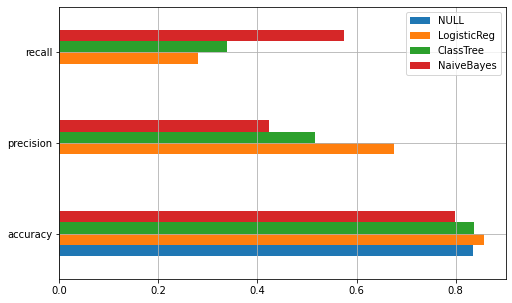

In [32]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [33]:
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=NBC.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=logistic_regression.predict_proba(X_test)[:,1])

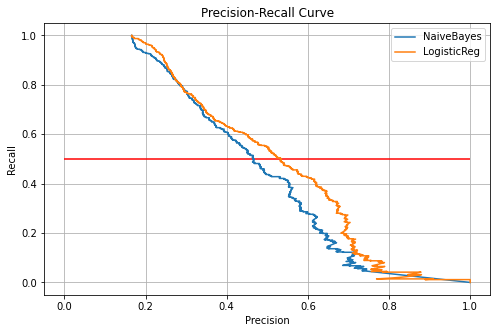

In [34]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_lr, recall_lr, label='LogisticReg')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

### Matriz de confusión para el clasificador de regresión logística modificado

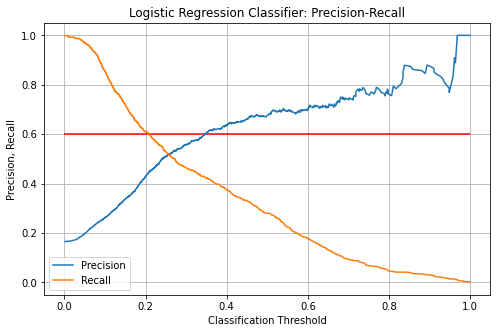

In [36]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Regression Classifier: Precision-Recall')
ax.hlines(y=0.6, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

### Clasificador con umbral de 0,2

In [38]:
y_pred_proba = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.2).astype('int')
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall: ", 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print("Precision: ", 100*precision_score(y_pred=y_pred_test, y_true=y_test))
CMatrix(CM)

Recall:  61.06321839080459
Precision:  42.88597376387487


PREDICTION,pay,default,Total
TRUE,,,
pay,2938,566,3504
default,271,425,696
Total,3209,991,4200


### Hacer predicciones individuales

In [39]:
def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    data = robust_scaler.transform(data)
    prob = logistic_regression.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Incumplirá'
    else:
        return 'Pagará'

In [40]:
from collections import OrderedDict
new_customer = OrderedDict([('id', 17720),('limit_bal', 240000),('age', 50 ),('bill_amt1', 978),
                            ('bill_amt2', 193 ),('bill_amt3', 386 ),('bill_amt4', 579 ),
                            ('bill_amt5', 386 ),('bill_amt6', 193 ), ('pay_amt1', 193 ),('pay_amt2', 386 ),
                            ('pay_amt3', 386 ),('pay_amt4', 0 ),('pay_amt5', 0 ), ('pay_amt6', 536 ),
                            ('hombre', 2 ),('graduado_de_secundaria', 1 ),('universidad', 0 ), ('secundaria', 0 ),
                            ('casado', 1 ),('pay_1', -1 ),('pay_2', -1 ),('pay_3', -1 ),
                            ('pay_4', 2),('pay_5', 0), ('pay_6', 0)])

new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

'Incumplirá'